# IMPORT DATASETS AND LIBRARIES

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read stock prices data
stock_price_df = pd.read_csv('/content/drive/MyDrive/A K61 NCKH/Crawl dữ liệu đầu vào /Microsoft.csv')
stock_price_df

,Date,Close
0,2011-01-03,22.061127
1,2011-01-04,22.147865
2,2011-01-05,22.076897
3,2011-01-06,22.723434
4,2011-01-07,22.549980
...,...,...
2763,2021-12-23,334.690002
2764,2021-12-27,342.450012
2765,2021-12-28,341.250000
2766,2021-12-29,341.950012


In [ ]:
import re

def clean_up_stock(text):
    text = re.sub(r'[^\w]', ' ', text)
    return text

In [ ]:
col = ['Close']
for i in col:
    stock_price_df[i] = stock_price_df[i].replace({r'\$':''}, regex = True)
    stock_price_df[i] = stock_price_df[i].astype(float)

stock_price_df

,Date,Close
0,2011-01-03,22.061127
1,2011-01-04,22.147865
2,2011-01-05,22.076897
3,2011-01-06,22.723434
4,2011-01-07,22.549980
...,...,...
2763,2021-12-23,334.690002
2764,2021-12-27,342.450012
2765,2021-12-28,341.250000
2766,2021-12-29,341.950012


In [ ]:
df = stock_price_df.reset_index()['Close']
df = df.iloc[::1].reset_index()['Close']
df

0        22.061127
1        22.147865
2        22.076897
3        22.723434
4        22.549980
           ...    
2763    334.690002
2764    342.450012
2765    341.250000
2766    341.950012
2767    339.320007
Name: Close, Length: 2768, dtype: float64

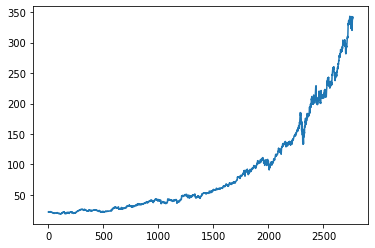

In [ ]:
plt.plot(df)

# MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(df)

[[0.00966425]
 [0.00993181]
 [0.0097129 ]
 ...
 [0.99426252]
 [0.99642184]
 [0.9883091 ]]


# Splitting Data to train test

In [ ]:
training_size = int(len(df) * 0.8)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:1]

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
feature = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , feature)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , feature)

In [ ]:
### Create the Stacked LSTM model

from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.models import Sequential

In [ ]:
model= Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, feature)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
34/34 [==============================] - 21s 345ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 2/100
34/34 [==============================] - 13s 391ms/step - loss: 7.3452e-05 - val_loss: 0.0010
Epoch 3/100
34/34 [==============================] - 25s 736ms/step - loss: 4.5556e-05 - val_loss: 0.0014
Epoch 4/100
34/34 [==============================] - 21s 601ms/step - loss: 4.3160e-05 - val_loss: 0.0023
Epoch 5/100
34/34 [==============================] - 12s 348ms/step - loss: 3.4739e-05 - val_loss: 0.0030
Epoch 6/100
34/34 [==============================] - 11s 322ms/step - loss: 4.3836e-05 - val_loss: 0.0033
Epoch 7/100
34/34 [==============================] - 11s 322ms/step - loss: 3.4305e-05 - val_loss: 0.0037
Epoch 8/100
34/34 [==============================] - 11s 324ms/step - loss: 3.6226e-05 - val_loss: 0.0031
Epoch 9/100
34/34 [==============================] - 11s 322ms/step - loss: 3.4339e-05 - val_loss: 0.0036
Epoch 10/100
34/34 [==============================

In [ ]:
# Prediction and check performances
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# Inverse transform to original close price
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# # Calculate RMSE performance metrics
# import math
# from sklearn.metrics import mean_squared_error
# math.sqrt(mean_squared_error(y_train,train_predict))
import math
from sklearn.metrics import mean_absolute_error, accuracy_score
# accuracy_score(y_train, train_predict) 
math.sqrt(mean_absolute_error(y_train,train_predict))

7.341352247771015

In [ ]:
# Test Data MAE
math.sqrt(mean_absolute_error(y_test,test_predict))

15.241393611769825

In [ ]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_true, y_pred, normalize = False)
# print('Test accuracy: {:4f}'.format(results[1]))
# clf = DecisionTreeClassifier(max_depth=3).fit(X_train,Y_train)
# clf.score(y_test, test_predict)

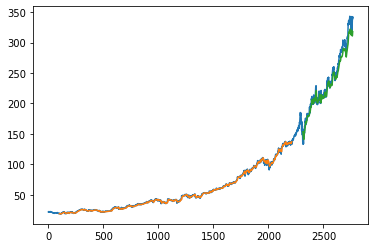

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

554

In [ ]:
x_input=test_data[454:].reshape(1,-1)
x_input.shape
x_input

array([[0.82189199, 0.82345938, 0.83224859, 0.84159096, 0.84696912,
        0.84229784, 0.83678639, 0.85538376, 0.8787538 , 0.87964678,
        0.87339626, 0.87151813, 0.86252727, 0.86446706, 0.87638295,
        0.87111786, 0.87096385, 0.86887005, 0.86883936, 0.86588335,
        0.8659757 , 0.85686181, 0.85212002, 0.85606117, 0.86468263,
        0.88017028, 0.88140188, 0.8649289 , 0.84777851, 0.84931803,
        0.86095687, 0.86397435, 0.86332781, 0.84737833, 0.81458629,
        0.81606424, 0.8096599 , 0.83176746, 0.81332391, 0.83072065,
        0.8441144 , 0.84947204, 0.84947204, 0.84756303, 0.8434063 ,
        0.85396746, 0.87379653, 0.87829196, 0.88777553, 0.89066987,
        0.88814502, 0.89845982, 0.89353334, 0.89036195, 0.89645837,
        0.93667097, 0.9403042 , 0.9626889 , 0.95576106, 0.96733834,
        0.97001701, 0.97752992, 0.97635988, 0.97922344, 0.97602127,
        0.96016404, 0.96518288, 0.97839212, 0.97639076, 0.9869827 ,
        0.98769212, 0.99432418, 1.        , 0.98

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8218919940673545,
 0.8234593788608213,
 0.8322485949945649,
 0.8415909614614263,
 0.8469691152533517,
 0.8422978378826962,
 0.8367863857804074,
 0.8553837593694854,
 0.8787537961203638,
 0.8796467818351281,
 0.8733962583806768,
 0.8715181266080366,
 0.8625272685387011,
 0.8644670601936068,
 0.8763829501129483,
 0.8711178551280474,
 0.8709638466282208,
 0.8688700464734885,
 0.8688393577381931,
 0.8658833547412169,
 0.8659757033587779,
 0.8568618079365858,
 0.8521200217845305,
 0.8560611708393825,
 0.8646826344384739,
 0.8801702789424236,
 0.8814018762549117,
 0.8649288974186367,
 0.8477785071124645,
 0.8493180272873808,
 0.8609568713540395,
 0.8639743459588316,
 0.8633278114986797,
 0.8473783297697001,
 0.8145862864597517,
 0.8160642408896274,
 0.8096598972097991,
 0.8317674596384442,
 0.8133239062747432,
 0.830720653698303,
 0.8441144039102956,
 0.8494720357872074,
 0.8494720357872074,
 0.8475630270048221,
 0.8434063037051027,
 0.8539674648218751,
 0.873796529860666,
 0.878291958895

In [ ]:
# Prediction for next 30 days

lst_output=[]
n_steps=100
i=0
while(i<30):

    if len(temp_input)>100:
        # Shifting x_input to next day
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        # Predict next day
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.9362822]
101
1 day input [0.82345938 0.83224859 0.84159096 0.84696912 0.84229784 0.83678639
 0.85538376 0.8787538  0.87964678 0.87339626 0.87151813 0.86252727
 0.86446706 0.87638295 0.87111786 0.87096385 0.86887005 0.86883936
 0.86588335 0.8659757  0.85686181 0.85212002 0.85606117 0.86468263
 0.88017028 0.88140188 0.8649289  0.84777851 0.84931803 0.86095687
 0.86397435 0.86332781 0.84737833 0.81458629 0.81606424 0.8096599
 0.83176746 0.81332391 0.83072065 0.8441144  0.84947204 0.84947204
 0.84756303 0.8434063  0.85396746 0.87379653 0.87829196 0.88777553
 0.89066987 0.88814502 0.89845982 0.89353334 0.89036195 0.89645837
 0.93667097 0.9403042  0.9626889  0.95576106 0.96733834 0.97001701
 0.97752992 0.97635988 0.97922344 0.97602127 0.96016404 0.96518288
 0.97839212 0.97639076 0.9869827  0.98769212 0.99432418 1.
 0.98988223 0.98325016 0.98395968 0.95857265 0.98001128 0.96137973
 0.95980651 0.95798656 0.93799783 0.94780712 0.97473649 0.97489068
 0.96912233 0.9982418  0.98855583 0.9544391

In [ ]:
print(lst_output)

[[0.936282217502594], [0.9334444999694824], [0.9243515729904175], [0.9119424819946289], [0.8983541131019592], [0.8848272562026978], [0.8719776272773743], [0.8600664734840393], [0.8491751551628113], [0.839299738407135], [0.8303900361061096], [0.8223697543144226], [0.8151459693908691], [0.80861496925354], [0.8026695251464844], [0.7972036004066467], [0.7921192646026611], [0.7873274683952332], [0.7827526330947876], [0.7783318161964417], [0.7740166783332825], [0.7697707414627075], [0.7655690312385559], [0.7613968253135681], [0.7572472095489502], [0.7531195282936096], [0.749017596244812], [0.7449485063552856], [0.7409210205078125], [0.7369442582130432]]


In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df)

2768

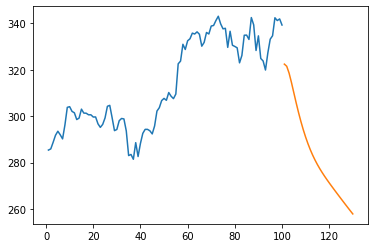

In [ ]:
# Plot real 100 close value
plt.plot(day_new,scaler.inverse_transform(df[2668:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df_new=df.tolist()
df_new.extend(lst_output)

In [ ]:
len(df_new)

2798

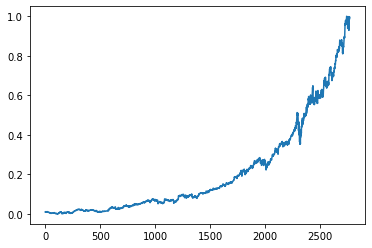

In [ ]:
plt.plot(df)

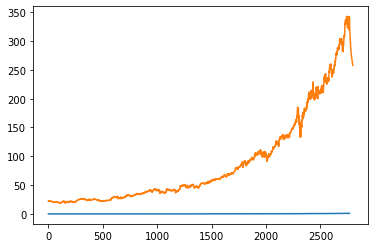

In [ ]:
df_new=scaler.inverse_transform(df_new).tolist()
# plt.subplots(old_df, df_new)
plt.plot(df)
plt.plot(df_new)